In [1]:
%pip install Sastrawi
import nltk
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from transformers import TFBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.preprocessing import LabelEncoder

label_type = ['ham', 'spam']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  infl

2024-12-05 09:24:49.287149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 09:24:49.287264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 09:24:49.427262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/spam-dataset-indo/spam_dataset_indo.csv')
data['Pesan'] = data['Pesan'].astype(str)
texts = data['Pesan'].values
labels = data['Kategori'].values

In [3]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    for index, text in enumerate(texts):
        text = text.lower()

        text = re.sub(pattern, '', text)

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        word_list = [lemmatizer.lemmatize(word) for word in word_list]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [4]:
texts = preprocess_text(texts)

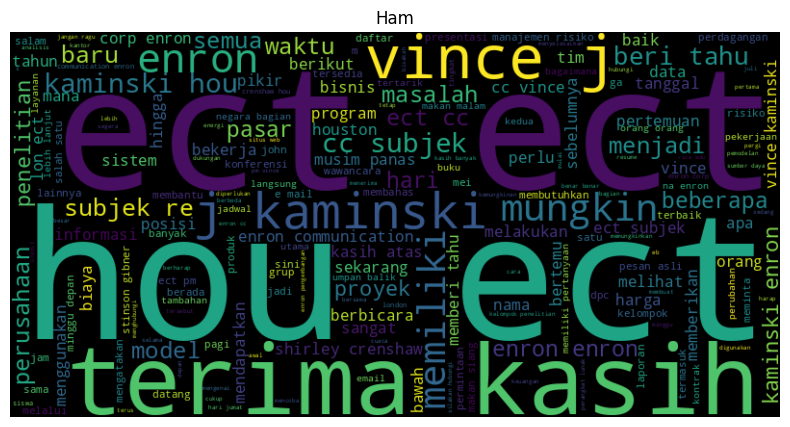

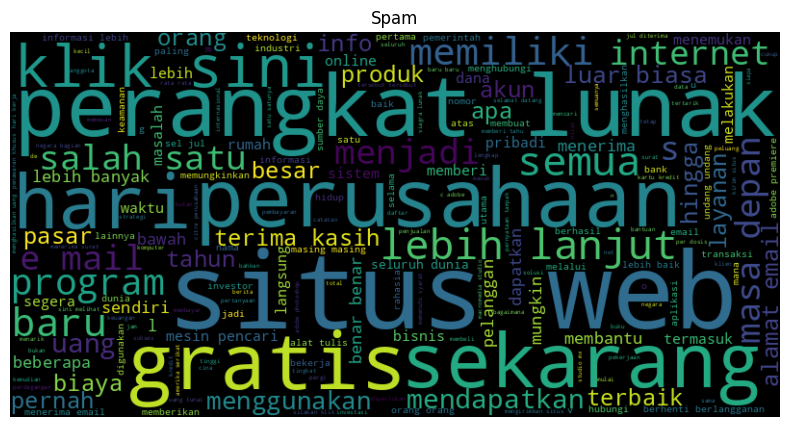

In [5]:
def generate_wordcloud(text,Title):
    all_text = "".join(str(text))
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()
    
ham = texts[labels=='ham'].tolist()
generate_wordcloud(ham,'Ham')

spam = texts[labels=='spam'].tolist()
generate_wordcloud(spam,'Spam')

In [6]:
train_texts, tests_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

In [8]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(tests_texts.tolist())


In [9]:
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform(test_labels)

In [11]:
model = TFBertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=2, from_pt=True)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
epochs = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
history = model.fit(
    [train_encodings['input_ids'], train_encodings['token_type_ids'], train_encodings['attention_mask']],
    train_labels, validation_split = 0.1,
    batch_size=16,
    epochs=epochs
)

Epoch 1/2
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1733390941.537939     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 [==============================] - 259s 1s/step - loss: 0.2169 - accuracy: 0.9140 - val_loss: 0.0904 - val_accuracy: 0.9703
Epoch 2/2
170/170 [==============================] - 186s 1s/step - loss: 0.0633 - accuracy: 0.9787 - val_loss: 0.1542 - val_accuracy: 0.9472


24/24 [==============================] - 24s 668ms/step
Accuracy Score: 0.9537037037037037
Recall Score: 0.9746478873239437
Precision Score: 0.9301075268817204
F1 Score: 0.951856946354883
Classification Report:               precision    recall  f1-score   support

         ham       0.94      0.98      0.96       384
        spam       0.97      0.93      0.95       372

    accuracy                           0.95       756
   macro avg       0.95      0.95      0.95       756
weighted avg       0.95      0.95      0.95       756

Confusion Matrix:



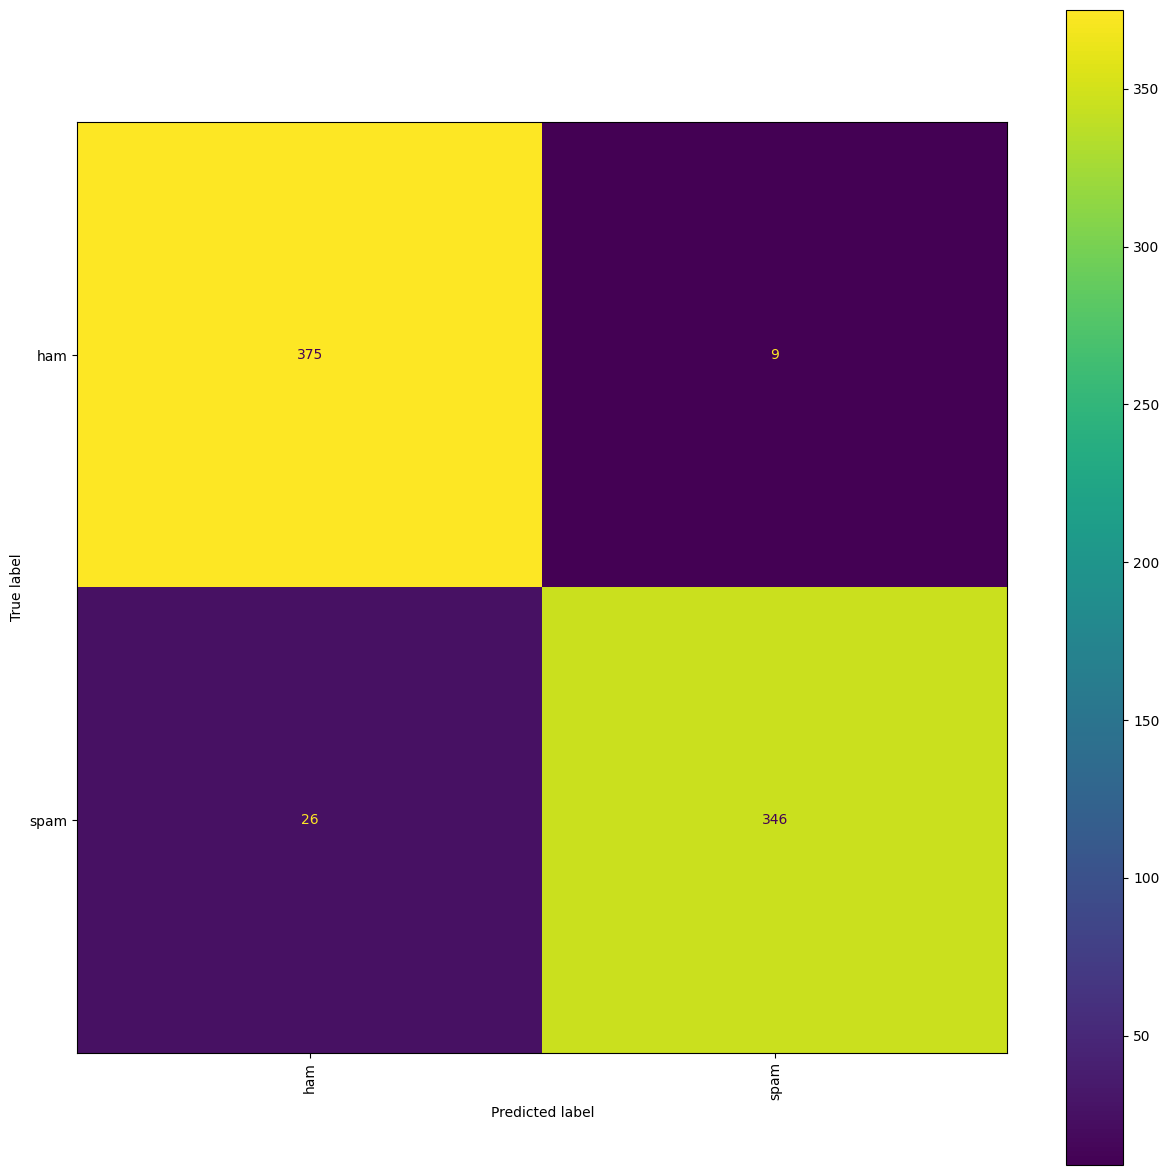

In [14]:
pred = model.predict([test_encodings['input_ids'], test_encodings['token_type_ids'], test_encodings['attention_mask']])
pred_labels = tf.argmax(pred.logits, axis=1)

print(f"Accuracy Score: {accuracy_score(pred_labels, test_labels)}")
print(f"Recall Score: {recall_score(pred_labels, test_labels)}")
print(f"Precision Score: {precision_score(pred_labels, test_labels)}")
print(f"F1 Score: {f1_score(pred_labels, test_labels)}")
print(f"Classification Report: {classification_report(test_labels, pred_labels, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [16]:
model.save_pretrained('spam_identification_model')

In [17]:
model = TFBertForSequenceClassification.from_pretrained('spam_identification_model')

Some layers from the model checkpoint at spam_identification_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at spam_identification_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [18]:
def predict_sentiment(text):
    use_text = preprocess_text(text)
    encoding = tokenize_function(use_text)
    pred = model.predict([encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']])
    pred_labels = tf.argmax(pred.logits, axis=1)
 
    pred_labels = [label_type[i] for i in pred_labels.numpy().tolist()]
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}: {pred}")


In [19]:
from IPython.display import FileLink
FileLink('spam_identification_model/tf_model.h5')

/kaggle/working/spam_identification_model/tf_model.h5